In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
from trainer import Trainer
from losses import SupConLoss
from utils import WarmUpScheduler, LearningRateAdjuster, TwoCropTransform
from models import LinearClassifier, SupCEResNet, SupConResNet

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm

In [97]:
args = dict(
    temp = 0.07,
    epochs = 100, 
    # optimization
    lr_step_size = 10,
    lr_gamma = 0.1, 
    lr = 0.005, 
    lr_decay_epochs = [70, 80, 90],
    lr_decay_rate = 0.01,
    weight_decay = 1e-4,
    momentum = 0.9, 
    base_lr = 0.01, 
    size = 32
    
)
args = SimpleNamespace(**args)
args.target_lr = args.lr

In [109]:
# Define data transformations
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=args.size, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=TwoCropTransform(transform), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [99]:
def contrastive_forward_fn(model, inputs, labels, loss_fn):
    images = torch.cat([inputs[0], inputs[1]], dim=0)  # Combine augmented views
    
    if torch.cuda.is_available():
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
    features = model(images)
    
    bsz = labels.shape[0]
    f1, f2 = torch.split(features, [bsz, bsz], dim=0)
    features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
    loss = loss_fn(features, labels)
    return features, loss

In [6]:
# Load a pre-trained ResNet-18 and adapt it for CIFAR-10
class ResNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.resnet = resnet18(ResNet18_Weights.IMAGENET1K_V1)  # Set to True for pretraining
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)



In [113]:
model = SupConResNet('resnet50')
supconloss = SupConLoss(temperature=args.temp)
model = model.cuda()
supconloss = supconloss.cuda()

In [7]:
from types import SimpleNamespace

In [25]:
model = ResNetCIFAR(num_classes=10).to("cuda")
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)


/home/abijuru/.conda/envs/pap3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [115]:
optimizer = optim.SGD(model.parameters(),
          lr=args.lr,
          momentum=args.momentum,
          weight_decay=args.weight_decay)

In [116]:
##schedulers

warmup_scheduler = WarmUpScheduler(
    optimizer, 
    warmup_epochs= 10, 
    base_lr= args.base_lr, 
    target_lr = args.target_lr
)

lr_adjuster = LearningRateAdjuster(
    optimizer, args.base_lr, args.epochs, 
    lr_decay_rate=args.lr_decay_rate, 
    lr_decay_epochs= args.lr_decay_epochs, 
    cosine=False
)

In [118]:
trainer = Trainer(
    model = model,
    train_loader=train_loader,
    #val_loader=test_loader, 
    optimizer=optimizer, 
    loss_fn=supconloss,
    lr_warmup_scheduler= warmup_scheduler, 
    lr_adjuster= lr_adjuster, 
    forward_fn=contrastive_forward_fn,
    save_freq = 1
)
trainer.fit(10)

Training Epoch 1: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 1/10 - Train Loss: 5.4773, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 2: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 2/10 - Train Loss: 5.4154, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 3: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 3/10 - Train Loss: 5.3893, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 4: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 4/10 - Train Loss: 5.3624, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 5: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 5/10 - Train Loss: 5.3310, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 6: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 6/10 - Train Loss: 5.2889, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 7: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 7/10 - Train Loss: 5.2435, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 8: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 8/10 - Train Loss: 5.1969, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 9: 100%|██████████| 391/391 [02:00<00:00,  3.24it/s]


Epoch 9/10 - Train Loss: 5.1551, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


Training Epoch 10: 100%|██████████| 391/391 [02:00<00:00,  3.23it/s]


Epoch 10/10 - Train Loss: 5.1330, Train Accuracy: 0.0000 - Val Loss: 0.0000, Val Accuracy: 0.0000
==> Saving...


In [111]:
import gc
torch.cuda.empty_cache()
gc.collect()

7818

Training Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

torch.Size([128, 3, 32, 32]) torch.Size([64, 3, 32, 32])


TypeError: iteration over a 0-d tensor

In [22]:
torch.save(model.state_dict(), 'output/models/best_model.pth')

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, labels, predictions, class_names, n=5, max_per_row=8):
    """
    Plot sample images with their predicted and true labels.
    Args:
        images: Tensor of images.
        labels: Tensor of true labels.
        predictions: Tensor of predicted labels.
        class_names: List of class names corresponding to CIFAR-10 classes.
        n: Number of images to display.
    """
    # Ensure n is not greater than the number of available images
    n = min(n, len(images))
    # Calculate rows and columns
    rows = (n + max_per_row - 1) // max_per_row  # Ceiling division
    cols = min(n, max_per_row)

    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        row, col = divmod(i, max_per_row)
        plt.subplot(rows, cols, i + 1)
        image = images[i].permute(1, 2, 0).cpu().numpy()
        image = (image * 0.247 + 0.4914).clip(0, 1)  # De-normalize for visualization
        
        true_label = class_names[labels[i].item()]
        predicted_label = class_names[predictions[i].item()]
        
        plt.imshow(image)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=14)
        plt.axis("off")
    plt.show()

In [23]:
# Get a batch of images and labels from the test loader
images, labels = next(iter(test_loader))
images, labels = images.to("cuda"), labels.to("cuda")
# Use the trained model to predict
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, dim=1)

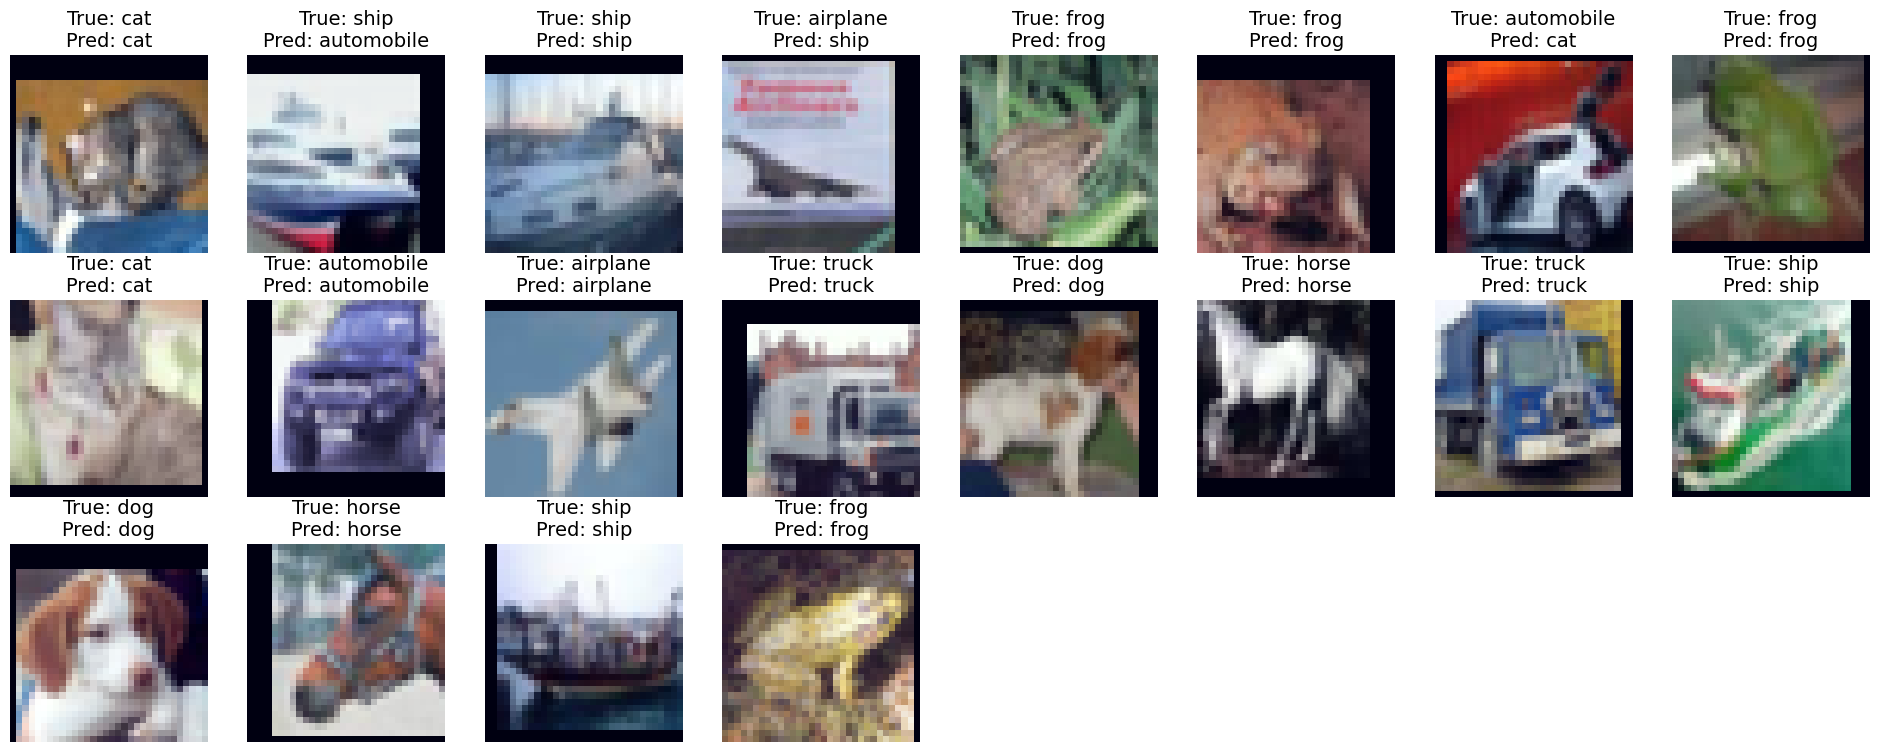

In [34]:
# Define CIFAR-10 class names
class_names = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

# Plot the predictions
plot_predictions(images, labels, predictions, class_names, n=20)

In [36]:
re = None
x = re or re
x